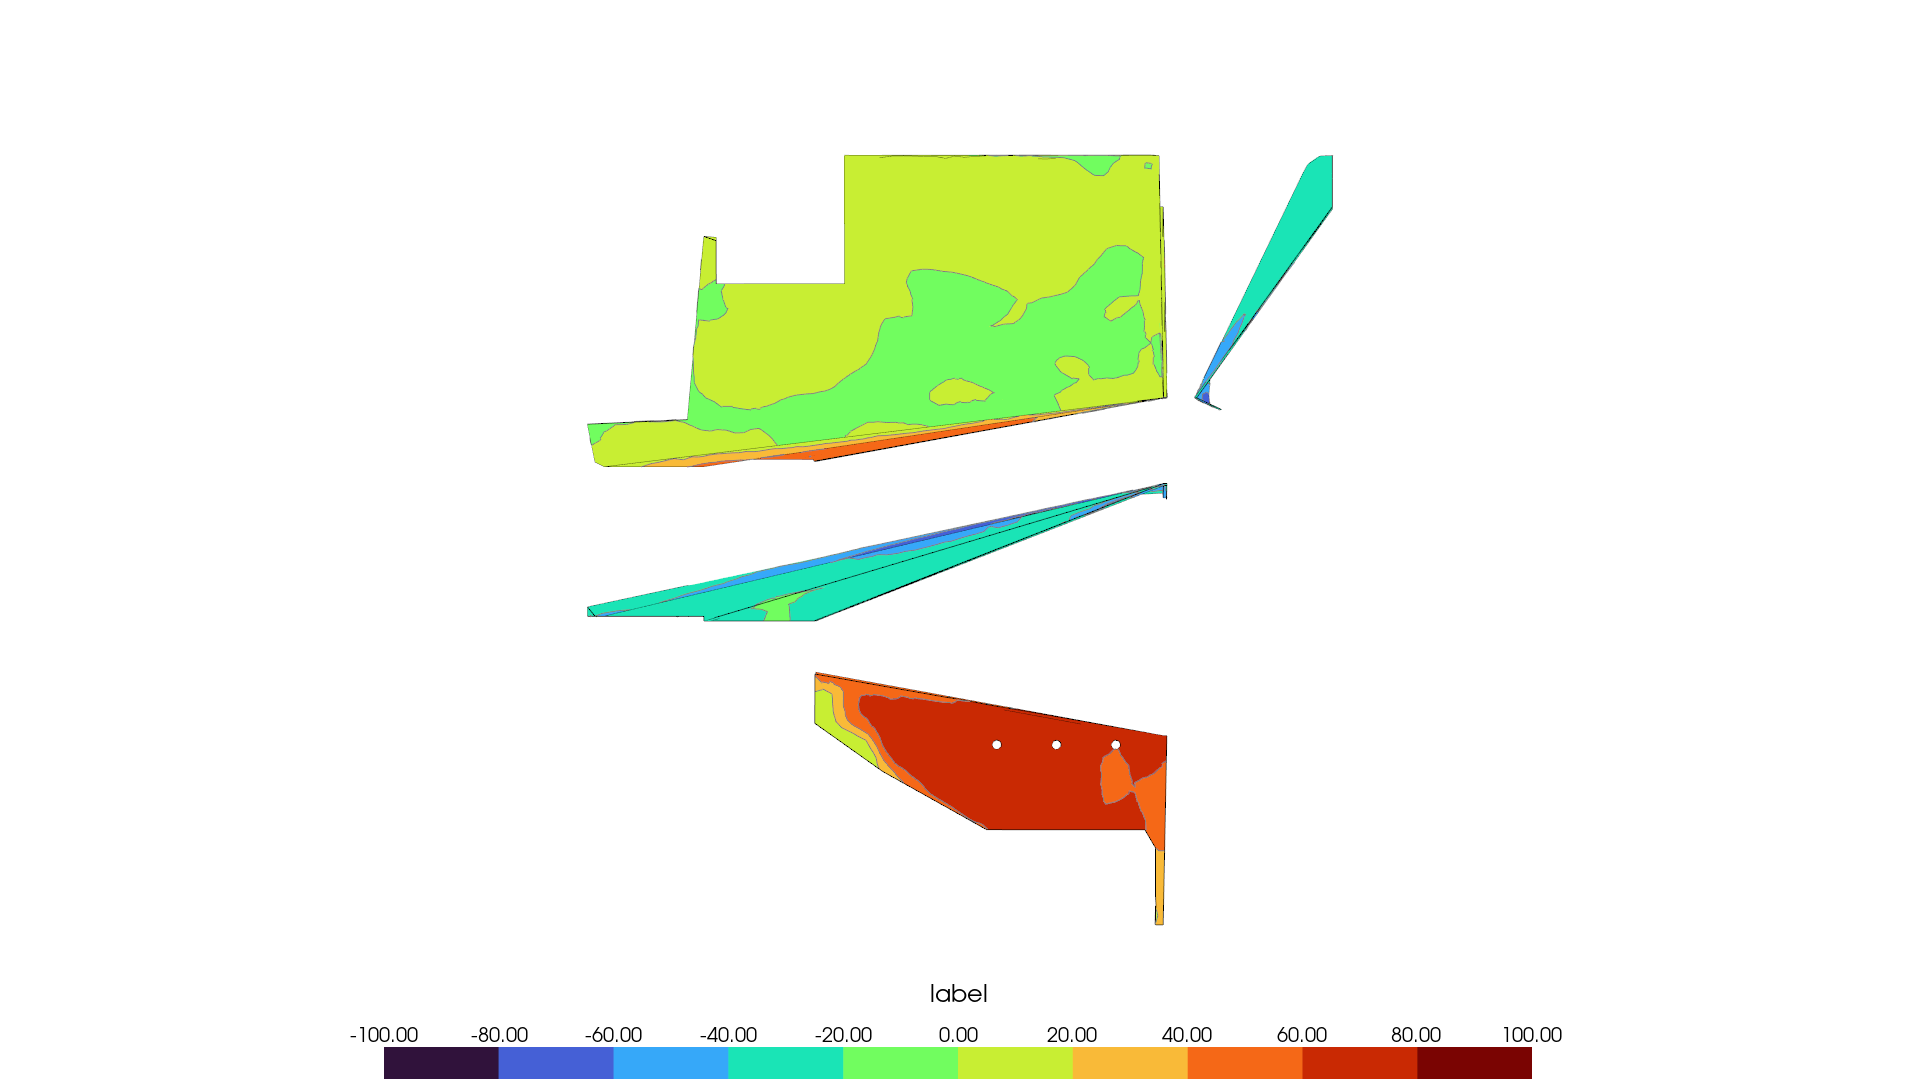

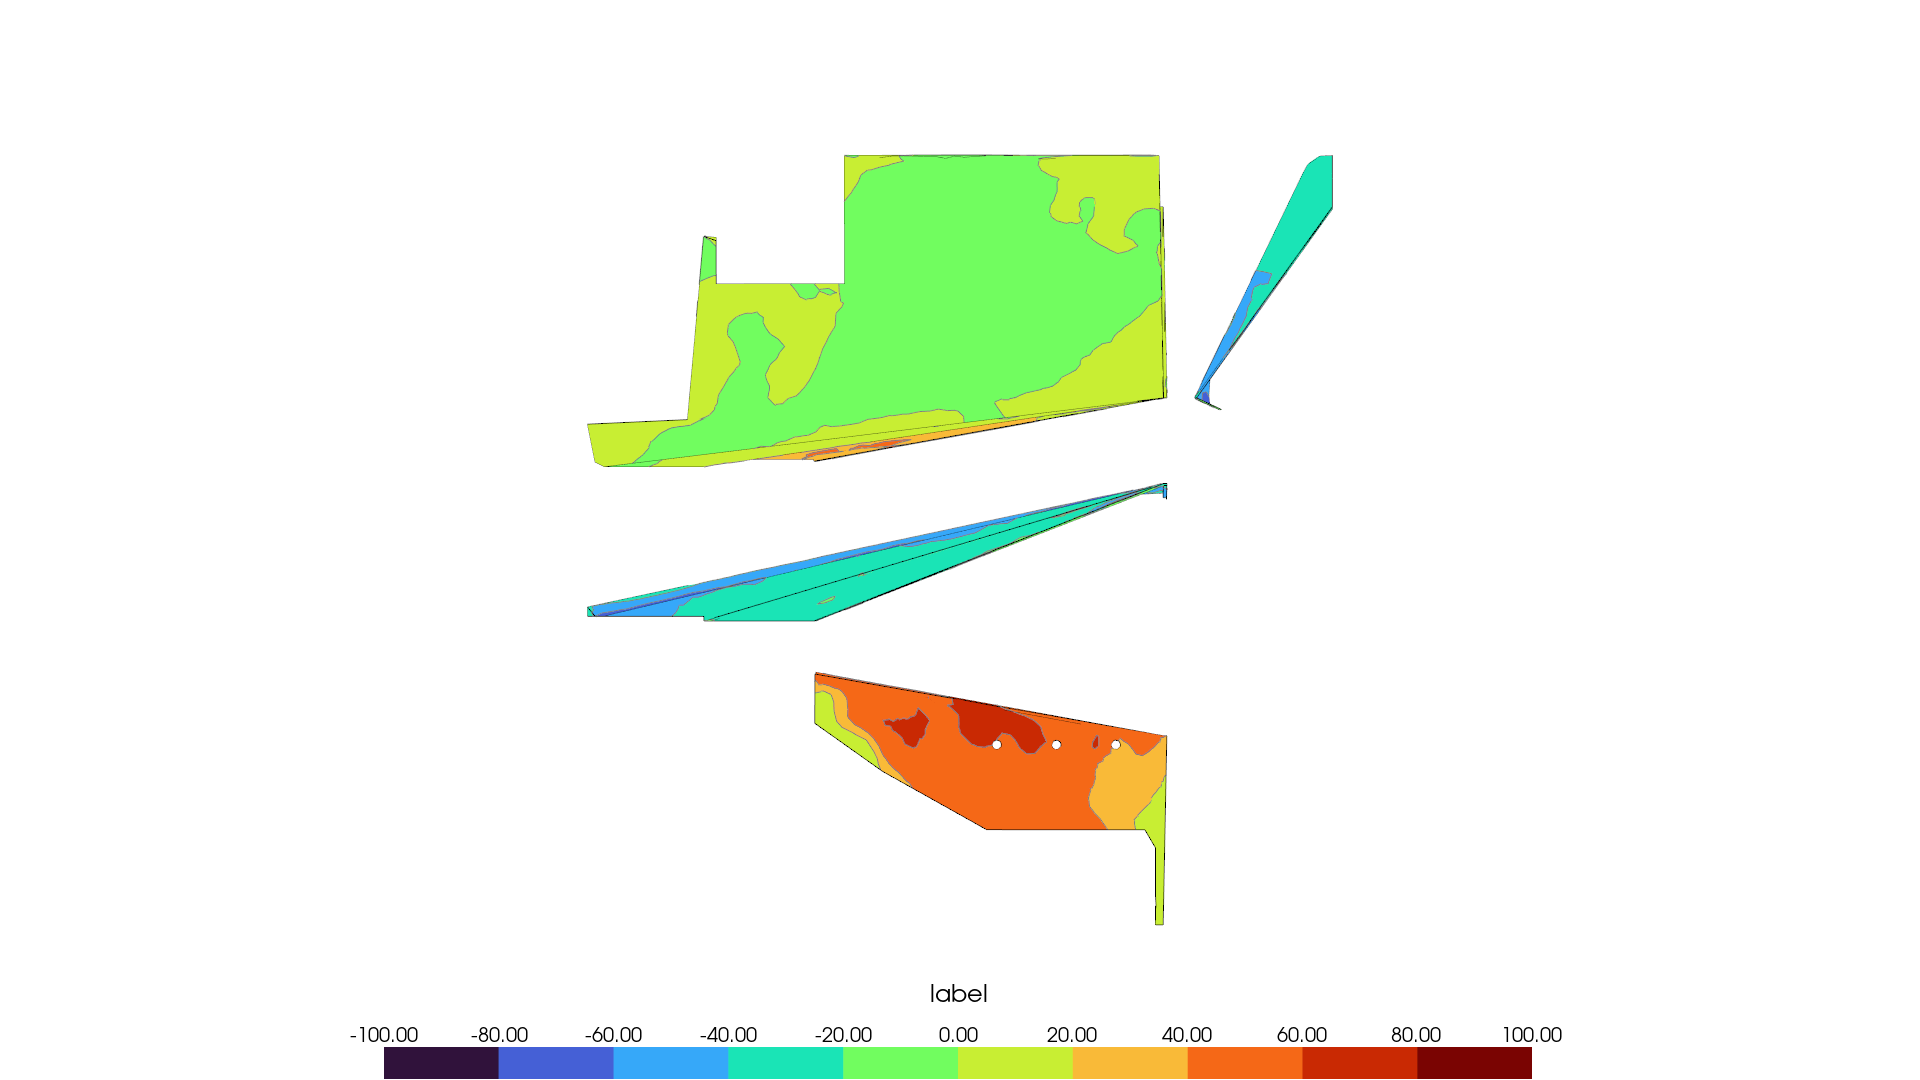

In [ ]:
import pathlib

from cfdmod.use_cases.snapshot.camera import take_snapshot
from cfdmod.use_cases.snapshot.config import (
    LegendConfig,
    ImageConfig,
    PartialProjectionConfig,
    SnapshotConfig,
)
from cfdmod.use_cases.snapshot.process_image import process_image
from cfdmod.utils import create_folder_path
import warnings

files_path = pathlib.Path("../fixtures/tests/snapshot")
wind_dirs = ["006", "036"]
images = [
    ImageConfig(
        name=f"{wind_dir}",
        legend_config=LegendConfig(label="label", range=[-100, 100], n_divs=10),
        projections={
            "top_projection": PartialProjectionConfig(
                file_path=files_path / f"loads_cupula_top_{wind_dir}.vtp", scalar="max [kgf/m²]"
            ),
            "left_projection": PartialProjectionConfig(
                file_path=files_path / f"loads_cupula_top_{wind_dir}.vtp", scalar="min [kgf/m²]"
            ),
            "right_projection": PartialProjectionConfig(
                file_path=files_path / f"loads_cupula_top_{wind_dir}.vtp", scalar="min [kgf/m²]"
            ),
            "bottom_projection": PartialProjectionConfig(
                file_path=files_path / f"loads_cupula_bottom_{wind_dir}.vtp", scalar="max [kgf/m²]"
            ),
        },
    )
    for wind_dir in wind_dirs
]

snapshot_config_path = files_path / "snapshot_params_example.yaml"
snapshot_config = SnapshotConfig.from_file(snapshot_config_path)
output_path = pathlib.Path("./output/images")
create_folder_path(output_path)

for image in images:
    for projection_key in image.projections:
        snapshot_config.name = output_path / image.name
        snapshot_config.projections[projection_key].file_path = image.projections[
            projection_key
        ].file_path
        snapshot_config.projections[projection_key].scalar = image.projections[
            projection_key
        ].scalar
        snapshot_config.legend_config.label = image.legend_config.label
        snapshot_config.legend_config.range = image.legend_config.range
        snapshot_config.legend_config.n_divs = image.legend_config.n_divs

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        take_snapshot(snapshot_config)
    process_image(
        image_path=output_path / f"{image.name}.png",
        output_path=output_path / f"{image.name}.png",
        crop_cfg=snapshot_config.camera.crop,
    )

In [ ]:
from PIL import Image
import pathlib


def paste_watermark(main_image: Image, watermark_image: Image):
    """Adds a watermark to the main image

    Args:
        main_image (Image): Main Image
        watermark_image (Image): Watermark image
    """
    OFFSET = 40
    # position = (main_image.size[0] - watermark_image.size[0] - OFFSET, main_image.size[1] - watermark_image.size[1] - OFFSET)
    position = (OFFSET, OFFSET)
    main_image.paste(
        watermark_image,
        position,
        watermark_image,
    )


images_path = output_path
watermark_path = pathlib.Path("./fixtures/tests/snapshot/dark_logo.png")

watermark_img = Image.open(watermark_path)
w_size = (int(s * 0.2) for s in watermark_img.size)
watermark_img = watermark_img.resize(w_size)

image_prefix = ""

files_list = [f for f in images_path.iterdir() if f.is_file()]
files_list = [f for f in files_list if f.name.startswith(image_prefix)]

for file in files_list:
    t_img = Image.open(file)
    paste_watermark(t_img, watermark_img)
    t_img.save(file.parent / ("watermarked_" + file.name))
    print(file, file.parent / ("watermarked_" + file.name))

output/images/CP_ENVMAX_G100.png output/images/watermarked_CP_ENVMAX_G100.png
